## 1.데이터 분할

### 1.1 데이터 불러오기

In [2]:
import pandas as pd 
import numpy as np

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

### 1.2 단위 수정

In [5]:
train_x = train.drop('price',axis=1)
train_y = train['price']

### 1.3 validation set 분할 - 첫번째

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_test_split(train,test_size=0.2)

[         dong            apt  exclusive_use_area  floor   price  \
 314626    신림동         신림푸르지오             114.840     20   54500   
 63804     면목동  한강훼미리(138-28)              84.750      7   34000   
 294656    사당동          삼성래미안              84.967     11   47500   
 215988    신정동       목동신시가지14              71.370      5   60000   
 130116    상계동           현대4차              84.990     12   25500   
 ...       ...            ...                 ...    ...     ...   
 40633     이문동        이문동웰츠타워             112.134     13   50958   
 18548   성수동1가          LIG건영              73.912     19   53000   
 265128    구로동          다원그린빌             114.840     11   47000   
 347522    청담동    청담멤버스카운티10차             148.870      4  120000   
 372224    잠실동           잠실엘스              84.800     16   93800   
 
         transaction_year  until_trans      sin_date      cos_date  
 314626                 2           10  6.123234e-16 -1.000000e+00  
 63804                  3           12 -1.95

### 1.4 질문

시계열 데이터다 보니 데이터가 랜덤한 순서로 섞여 버리면 데이터들의 관계가 깨져버려서 분석이 제대로 되지 않을 것 같다.

### 1.5 validation set 분할 - 두번째

In [8]:
val_x = train_x[train_x['transaction_year']==4]
val_y = train[train['transaction_year']==4]
val_y = val_y['price']

train2_x = train_x[train_x['transaction_year']!=4]
train2_y = train[train['transaction_year']!=4]
train2_y = train2_y['price']

### 1.5 캣부스트 인코딩 전에

In [8]:
! pip install category_encoders

In [9]:
from category_encoders.cat_boost import CatBoostEncoder

### 1.6 캣부스트 인코딩

In [10]:
enc = CatBoostEncoder(cols=['dong','apt']).fit(train2_x,train2_y)
val_cbe= enc.transform(val_x)
val_cbe.head()

C:\Users\bounc\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
2451,89176.597368,86280.203194,107.91,14,4,9,-1.000000e+00,-1.836970e-16
2452,89176.597368,86280.203194,151.81,10,4,9,-1.000000e+00,-1.836970e-16
2453,89176.597368,86280.203194,94.51,2,4,9,-2.449294e-16,1.000000e+00
2454,89176.597368,86280.203194,94.28,12,4,9,-2.449294e-16,1.000000e+00
2455,103789.156533,107170.755379,145.96,13,4,13,-1.000000e+00,-1.836970e-16


## 2.릿지 회귀 (Ridge Regression)

### 2.1 상관계수 플랏

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns 

C:\Users\bounc\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


<AxesSubplot:>

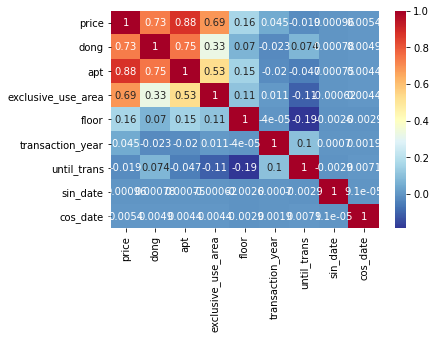

In [13]:
enc = CatBoostEncoder(cols=['dong','apt']).fit(train2_x,train2_y)
train2_x_cbe= enc.transform(train2_x)
a=pd.concat([train2_y,train2_x_cbe],axis=1)

sns.heatmap(a.corr(),annot=True,cmap = 'RdYlBu_r')

### 2.2 해석과 무관하게 일단 릿지 튜닝

In [15]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt

In [60]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1]

k=[]

for a in alphas:
    model = Ridge(alpha=a).fit(train2_x_cbe,train2_y)
    pred_y = model.predict(val_cbe)
    rmse = sqrt(mean_squared_error(val_y,pred_y))
    k.append(rmse)
    print("Alpha:{}, RMSE:{}" .format(a, rmse)) #alpha=0.00001일때 mse 최소

Alpha:1e-06, RMSE:15377.977659064007
Alpha:1e-05, RMSE:15377.977659081682
Alpha:0.0001, RMSE:15377.977659258442
Alpha:0.001, RMSE:15377.977661026036
Alpha:0.01, RMSE:15377.977678701962
Alpha:0.1, RMSE:15377.97785546123


### 2.3 튜닝결과 시각화

Text(0, 0.5, 'coefficient')

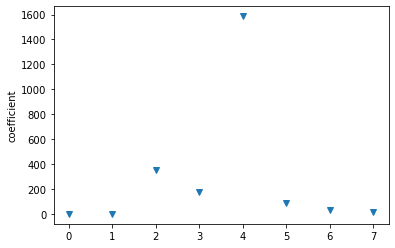

In [64]:
import matplotlib.pyplot as plt

ridge = Ridge(alpha=0.00001).fit(train2_x_cbe,train2_y)
plt.plot(ridge.coef_,'v')
plt.ylabel('coefficient')

In [63]:
ridge.coef_

array([3.04138142e-01, 6.24644960e-01, 3.51536564e+02, 1.77359082e+02,
       1.58652214e+03, 8.83005691e+01, 3.10879617e+01, 1.56919947e+01])

### 2.4 해석

### 2.5 그냥 선형 모형으로!

In [35]:
from sklearn.linear_model import LinearRegression

lm=LinearRegression().fit(train2_x_cbe,train2_y)
pred_y=lm.predict(val_cbe)
mse = mean_squared_error(val_y,pred_y)
sqrt(mse) 

15377.977659062773

## 3.LightGBM

In [134]:
! pip install lightgbm

### 3.1 LightGBM 이해

LightGBM은 leaf-wise로 트리가 수직적으로 확장된다. 따라서 균형 트리보다 예측오류를 최소화하고, 속도가 빠르다는 장점이 있다. 또한, 낮은 메모리 사용량, 병렬 및 GPU 학습 지원, 대규모 데이터 처리 가능이라는 장점이 있다. 하지만, 데이터셋이 작을 때는 오버피팅의 문제가 발생한다는 단점이 있다.

### 3.2 LGBM 튜닝

In [16]:
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor

rate = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.99]
ds =lgb.Dataset(train2_x_cbe,label=train2_y)
ds_t = lgb.Dataset(val_cbe,label=val_y)

m = []

for r in rate:
    param ={'learning_rate':r,'force_col_wise':True}
    model = lgb.train(param,train_set=ds,valid_sets=ds_t)
    y_pred = model.predict(val_cbe)
    rmse = sqrt(mean_squared_error(val_y,y_pred))
    m.append(rmse)

[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 312466, number of used features: 8
[LightGBM] [Info] Start training from score 46056.618349
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 312466, number of used features: 8
[LightGBM] [Info] Start training from score 46056.618349
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 312466, number of used features: 8
[LightGBM] [Info] Start training from score 46056.618349
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 312466, number of used features: 8
[LightGBM] [Info] Start training from score 46056.618349
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 312466, number of used features: 8
[LightGBM] [Info] Start training from score 46056.618349
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train

### 3.3 튜닝결과 시각화

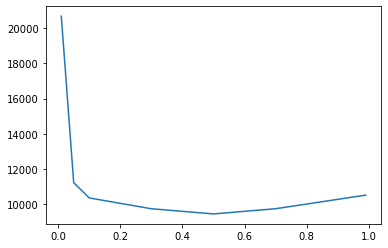

In [17]:
plt.plot(rate,m)

대략 0.5일때 rmse 최소!

### 3.4 튜닝에 대하여 알아보자

## 4. test set

### 4.1 test set 불러오기

In [41]:
test=pd.read_csv('test.csv')
test_x = test.drop('price',axis=1)
test_y = test['price']

### 4.2 캣부스트 인코딩

In [42]:
enc = CatBoostEncoder(cols=['dong','apt']).fit(train_x,train_y)
test_cbe= enc.transform(test_x)
test_cbe.head()

C:\Users\bounc\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
0,91827.227742,89369.051084,70.80,1,5,10,-1.000000e+00,-1.836970e-16
1,91827.227742,89369.051084,94.51,8,5,10,-2.449294e-16,1.000000e+00
2,91827.227742,89369.051084,160.85,11,5,10,-2.449294e-16,1.000000e+00
3,91827.227742,89369.051084,94.51,6,5,10,1.000000e+00,3.061617e-16
4,91827.227742,89369.051084,136.40,3,5,10,1.000000e+00,3.061617e-16


### 4.3 최적의 파라미터 적합

In [43]:
# Linesar Regression
enc = CatBoostEncoder(cols=['dong','apt']).fit(train_x,train_y)
train_x_cbe= enc.transform(train_x)
lm=LinearRegression().fit(train_x_cbe,train_y)


# LGBM
ds =lgb.Dataset(train_x_cbe,label=train_y)
ds_t = lgb.Dataset(test_cbe,label=test_y)

param ={'learning_rate':0.5,'force_col_wise':True}
model = lgb.train(param,train_set=ds,valid_sets=ds_t)


C:\Users\bounc\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 422164, number of used features: 8
[LightGBM] [Info] Start training from score 48041.092876


### 4.4 test set에 대해 평가

In [44]:
# Linesar Regression
pred_y=lm.predict(test_cbe)
rmse_linear = sqrt(mean_squared_error(test_y,pred_y))

# LGBM
y_pred = model.predict(test_cbe)
rmse_LGBM = sqrt(mean_squared_error(test_y,y_pred))

print(rmse_linear,rmse_LGBM)

17721.880605156384 11909.118492076514
